# Import the data


In [102]:
import string
from nltk.stem.porter import *

stemmer = PorterStemmer()

def simple_tokenize(s):
    """where s is a string of text, raw poem"""
    s = s.lower()
    s = s.translate(str.maketrans('', '', string.punctuation))
    return s.split(" ")

def get_stems(s):
    """where s is a list of lowercase words"""
    return [stemmer.stem(w) for w in s]


data_raw = []
data_tokens = []
data_stems = []
with open("part_a.txt", "r") as fle:
    for line in fle:
        if line[0] == "[":
            text = line.split("]")[1].strip()
            data_raw.append(text)
            
            tokens = simple_tokenize(text)
            data_tokens.append(tokens)
            
            stems = get_stems(tokens)
            data_stems.append(stems)

data_raw[0], ' '.join(data_tokens[0]), ' '.join(data_stems[0])

('I visualize two paths my life might take. The one where I have a child and the one where I do not. I try to place them on equal footing, imagining each as something I truly want. Though I know both will be filled with disappointment and loss.',
 'i visualize two paths my life might take the one where i have a child and the one where i do not i try to place them on equal footing imagining each as something i truly want though i know both will be filled with disappointment and loss',
 'i visual two path my life might take the one where i have a child and the one where i do not i tri to place them on equal foot imagin each as someth i truli want though i know both will be fill with disappoint and loss')

# Calculate transition scores

i.e. How well one poem flows into another. 

Look at the 10 words at the end of one poem, the ten at the start of the next. High score is better, but then we'll invert it so that score is more like distance.

Initial score: 0

If a word in poem B is in poem A (check for stemmed matches also):

* If not a stop word:
    * +10 if exact word match OR
    * +5 if stemmed word match
* If narrow stop word:
    * +2
* If broad stop word
    * +4
    
Not implemented: 

* Check number of words between them (k) -- could be up to 18
    * -k/4


In [103]:
stopwords_broad = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
stopwords_narrow = ["the", "a", "an"]

def join_score(a, b, n=10):
    """where a and b are indices for the data, and n is num of words to consider"""
    score = 0
    a_tokens = data_tokens[a]
    a_stems = data_stems[a]
    b_tokens = data_tokens[b]
    b_stems = data_stems[b]
    for i in range(min(len(a_tokens), n)): # iterate over words in a
        a_token = a_tokens[-i]
        a_stem = a_stems[-i]
        for j in range(min(len(b_tokens), n)): # iterate over words in b
            b_token = b_tokens[j]
            b_stem = b_stems[j]
#             print(a_token, b_token, score)
            if a_token == b_token: # if there's a matching word
                if a_token in stopwords_narrow:
                    score += 2
                    continue
                if a_token in stopwords_broad:
                    score += 4
                    continue
                score += 10
                continue
            if a_stem == b_stem:
                score += 5
#     a_set = set(a[-n:])
#     b_set = set(b[:n])
    return 20 - score

test = ("one way here dog why".split(" "), "one dog ready set go".split(" "))


p = 2
q = 3
print(data_raw[p])
print(data_raw[q])
join_score(p, q)

A mood sweeps in like a fog. I no longer know where it came from. I get stuck in circles. I try to ignore the suspense; anger and hurt can do that well, but not entirely. Suspense is lodged within me, someplace deep. The fog crawls at my feet. Let me stay, it mews, and though I definitely want it to leave, it doesn’t feel entirely up to me.
I pause to look carefully at the book cover. I am obsessed with the way books feel, how they look: their aspect ratio, the texture of the paper. If I put my nose close, I can see the dot matrix of the printed artwork. It’s not grey; it’s white with a multitude of black dots. The blue is more difficult to parse. Blue and purple and white?


12

## Attempted using BLEU scores

Didn't work very well!!

In [104]:
import nltk

def join_score_bleu(a, b):
    """where a and b are indices for the data"""
    bleu1 = nltk.translate.bleu([data_tokens[a]], data_tokens[b], weights=(1,0,0))
    bleu2 = nltk.translate.bleu([data_tokens[a]], data_tokens[b], weights=(0,1,0))
    bleu3 = nltk.translate.bleu([data_tokens[a]], data_tokens[b], weights=(0,0,1))
    return 1 - bleu1 + 10*bleu2 + 100*bleu3
    
join_score_bleu(0, 1), join_score_bleu(1,2)

(0.9268476621417797, 0.782608695652174)

In [105]:
import numpy as np

def calc_all_scores(data, join_score_func):
    scores = np.empty([len(data), len(data)])
    for i in range(len(data)):
        for j in range(len(data)):
            if i == j:
                s = np.nan
            else:
                s = join_score_func(i, j)
            scores[i][j] = s
    return scores

In [106]:
scores = calc_all_scores(raw_data, join_score)

In [107]:
scores

array([[nan,  2., 16., ..., 16.,  4., 16.],
       [12., nan, 16., ...,  8., 16., 16.],
       [20., 12., nan, ...,  8., 20., 16.],
       ...,
       [14., 18., 20., ..., nan, 20., 20.],
       [ 8., -8.,  8., ...,  4., nan,  8.],
       [ 8., -4., 12., ...,  4., 12., nan]])

# Get poems that fit together best

This is just to check that the join scores are working okay.

In [108]:
def get_top_scores(scores, asc=True, n=5):
    flattened = scores.flatten()
    if asc:
        sorted_indices = np.argsort(flattened)
    else:
        sorted_indices = np.argsort(-flattened)
    indices_2d = np.unravel_index(sorted_indices, scores.shape)
    sorted_indices_list = list(zip(indices_2d[0], indices_2d[1]))
    
    for i, val in enumerate(sorted_indices_list[0:n]):
        print('indices:', val)
        print('score:', scores[val[0],val[1]])
        print('>>>', data_raw[val[0]], '\n>>>>', data_raw[val[1]], '\n')

    return sorted_indices_list

In [109]:
x = get_top_scores(scores, asc=True, n=10)

indices: (166, 94)
score: -52.0
>>> I coat and slick and shine and look for words I haven't shared before: excess satiation and the opprobrium of the masses. The couch a winery red matching his backpack. The pine needles twinkle in the morning sun, about 20 percent glittering its long-traveled reflection, the rest providing backdrop and texture. It's not that I don't want to be here; I do. I just want it all to go my way and when it doesn't, when the world and the people within it are chaotically in my way, I of course doubt my own walking and dislike the resulting tension even though I know I deserve nothing more than all I have ever received (a lot) and it's fine to be sad I know but is it fine sit in the unknown of wanting and rebel uselessly against it? This is no good; I'll cut it later. Cut it down or out or up, reframe my experiences in a new way, feel them differently, be thankful for those wooded paths I didn't take or wasn't allowed to or my good stable horse refused to walk 

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 4.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 2.800e+01, 3.000e+00, 3.000e+01, 0.000e+00, 8.000e+00,
        4.700e+01, 3.000e+01, 2.000e+00, 1.740e+02, 5.200e+01, 6.000e+00,
        1.420e+02, 1.470e+02, 6.310e+02, 1.400e+01, 3.450e+02, 1.631e+03,
        3.200e+01, 8.110e+02, 4.064e+03, 1.202e+03, 2.600e+02, 6.646e+03,
        2.044e+03, 9.693e+03]),
 array([-52.  , -50.56, -49.12, -47.68, -46.24, -44.8 , -43.36, -41.92,
        -40.48, -39.04, -37.6 , -36.16, -34.72, -33.28, -31.84, -30.4 ,
        -28.96, -27.52, -26.08, -24.64, -23.2 , -21.76, -20.32, -18.88,
        -17.44, -16.  , -14.56, -13.12, -11.68, -10.24,  -8.8 ,  -7.36,
         -5.92,  -4.48,  -3.04,  -1.6 ,  -0.16,   1.28,   2.72,   4.16,
          5.6 , 

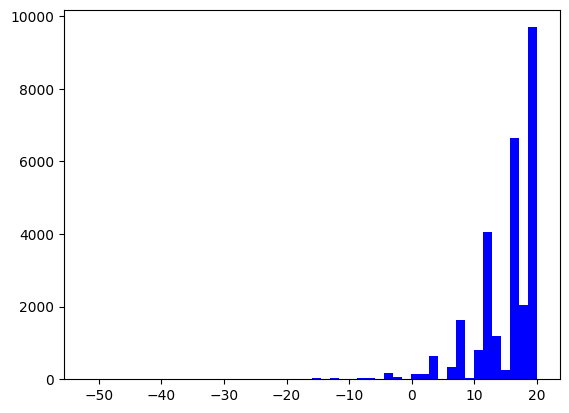

In [110]:
flattened = scores.flatten()
plt.hist(flattened, bins=50, color='b')


# Find 'best' path

This is a traveling salesman problem with assymetric distances. I'm going to use a Markov Chain Monte Carlo method to stochastically find a good path. The basic idea is to start with a random path, and then randomly swap "cities" and check if the new path is better; then we repeat this many times. However, to avoid local minimums, we add some wiggle room for selecting a slightly less optimal path. We'll add in simulated annealing, which means we'll decrease the wiggle room as we go on.

To keep in line with traveling salesman terminology, each poem is called 'city', and the ordering of the poems is called the 'tour'. The scores between poems are 'distances'.

Shouldn't take more than a second or two to run with 50k iterations.

In [112]:
import random
import math

def calculate_total_distance(tour, distance_matrix):
    return sum(distance_matrix[tour[i]][tour[i+1]] for i in range(len(tour)-1))

def swap_cities(tour):
    new_tour = tour[:]
    i, j = random.sample(range(len(tour)), 2)
    new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    return new_tour

def simulated_annealing_tsp(cities, distance_matrix, iterations, initial_temperature):
    current_tour = random.sample(cities, len(cities))
    current_distance = calculate_total_distance(current_tour, distance_matrix)
    best_tour = current_tour
    best_distance = current_distance

    temperature = initial_temperature

    down_sample = 100
    distance_array = np.empty(int(iterations/down_sample))

    for iteration in range(iterations):
        if iteration%down_sample == 0:
            distance_array[int(iteration/down_sample)] = current_distance
            
        new_tour = swap_cities(current_tour)
        new_distance = calculate_total_distance(new_tour, distance_matrix)
        delta_distance = new_distance - current_distance

        if delta_distance < 0 or random.random() < math.exp(-delta_distance / temperature):
            # print("new distance:", new_distance)
            current_tour = new_tour
            current_distance = new_distance
            if new_distance < best_distance:
                best_tour = new_tour
                best_distance = new_distance

        temperature *= 0.999  # Cooling schedule

    return best_tour, best_distance, distance_array

# Example usage
cities = list(range(len(raw_data)))  # Example cities
distance_matrix = scores  # Your asymmetric distance matrix
iterations = 50000
initial_temperature = 100

best_tour, best_distance, distance_array = simulated_annealing_tsp(cities, distance_matrix, iterations, initial_temperature)
print("Best Tour:", best_tour)
print("Best Distance:", best_distance)


Best Tour: [89, 88, 28, 15, 163, 116, 98, 96, 144, 147, 42, 45, 17, 149, 30, 164, 128, 127, 22, 134, 141, 54, 125, 24, 18, 25, 14, 110, 115, 122, 39, 61, 63, 143, 93, 9, 75, 142, 19, 50, 59, 12, 113, 34, 44, 123, 159, 160, 156, 66, 148, 91, 162, 130, 131, 2, 146, 21, 119, 114, 135, 97, 67, 5, 83, 139, 0, 16, 46, 43, 87, 109, 40, 31, 1, 137, 107, 55, 90, 84, 105, 102, 121, 153, 167, 81, 152, 124, 52, 76, 161, 117, 79, 154, 112, 53, 72, 64, 74, 157, 136, 140, 70, 41, 150, 29, 62, 145, 138, 3, 47, 132, 151, 10, 7, 108, 111, 78, 80, 13, 129, 118, 20, 23, 101, 94, 166, 56, 133, 8, 71, 58, 103, 104, 6, 68, 37, 155, 95, 51, 4, 92, 120, 32, 60, 106, 57, 36, 99, 73, 26, 11, 49, 82, 85, 158, 165, 48, 86, 65, 69, 33, 38, 27, 35, 126, 100, 77]
Best Distance: 825.0


# Make some plots to get a sense of how well TSP solver is working

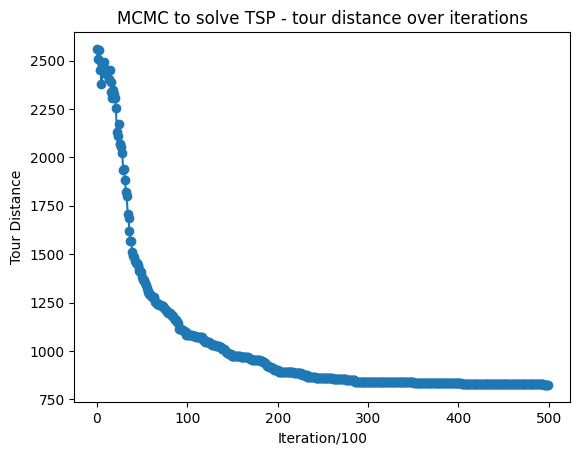

In [114]:
import matplotlib.pyplot as plt

# Generate x-axis values (indices of the array)
indices = np.arange(len(distance_array))

# Create a line plot
plt.plot(indices, distance_array, marker='o')

# Add titles and labels
plt.title('MCMC to solve TSP - tour distance over iterations')
plt.xlabel('Iteration/100')
plt.ylabel('Tour Distance')

# Show the plot
plt.show()


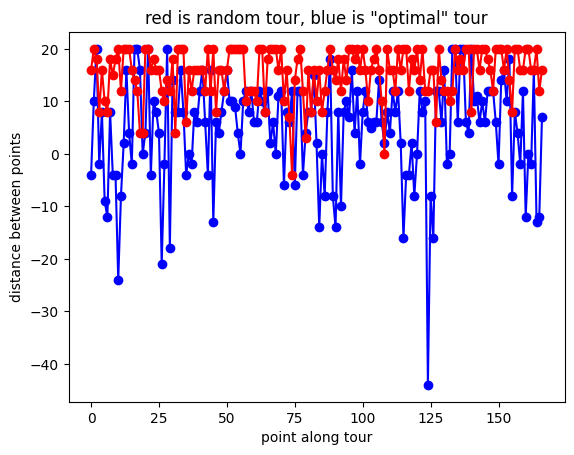

In [115]:
def get_tour_scores(tour):
    score_list = []
    for i in range(len(tour)-1):
        score_list.append(scores[tour[i], tour[i+1]])
    return score_list

random_tour = random.sample(list(range(len(raw_data))), len(raw_data))

best_score_list = get_tour_scores(best_tour)
rand_score_list = get_tour_scores(random_tour)

indices = np.arange(len(score_list))

# Create a line plot
plt.plot(indices, best_score_list, c='b', marker='o')
plt.plot(indices, rand_score_list, c='r', marker='o')

# Add titles and labels
plt.title('red is random tour, blue is "optimal" tour')
plt.xlabel('point along tour')
plt.ylabel('distance between points')

# Show the plot
plt.show()

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  3.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  8.,
         0.,  0.,  0.,  9.,  0.,  0.,  0., 23.,  0.,  0.,  0.,  8.,  0.,
         1.,  0., 41.,  0.,  0.,  0., 14.,  0.,  0.,  0., 54.]),
 array([-4.  , -3.52, -3.04, -2.56, -2.08, -1.6 , -1.12, -0.64, -0.16,
         0.32,  0.8 ,  1.28,  1.76,  2.24,  2.72,  3.2 ,  3.68,  4.16,
         4.64,  5.12,  5.6 ,  6.08,  6.56,  7.04,  7.52,  8.  ,  8.48,
         8.96,  9.44,  9.92, 10.4 , 10.88, 11.36, 11.84, 12.32, 12.8 ,
        13.28, 13.76, 14.24, 14.72, 15.2 , 15.68, 16.16, 16.64, 17.12,
        17.6 , 18.08, 18.56, 19.04, 19.52, 20.  ]),
 <BarContainer object of 50 artists>)

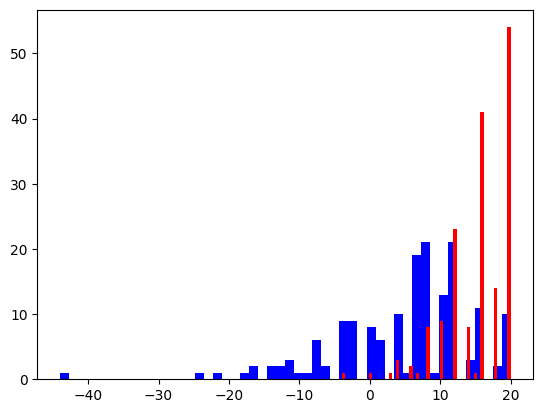

In [116]:
plt.hist(best_score_list, bins=50, color='b')
plt.hist(rand_score_list, bins=50,  color='r')

# Write best tour to txt file

In [71]:
with open('best_tour.txt', 'w') as fle:
    for i, index in enumerate(best_tour[:-1]):
        poem = raw_data[index]
        score = scores[index, best_tour[i+1]]
        fle.write(f"{poem}\n[{score}]\n")